# Kmeans voronoi partition

In [51]:
import numpy as np
X = np.zeros([133,2])

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = 2*vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [347]:
X[:33] = np.random.multivariate_normal([0.1, 0.1], 1e-2*np.diag(np.ones(2)),33)
X[33:66] = np.random.multivariate_normal([0.3, 0.8], 1e-2*np.diag(np.ones(2)),33)
X[66:100] = np.random.multivariate_normal([0.9, 0.4], 1e-2*np.diag(np.ones(2)),34)
X[100:133] = np.random.multivariate_normal([0.5, -0.4], 1e-2*np.diag(np.ones(2)),33)

x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

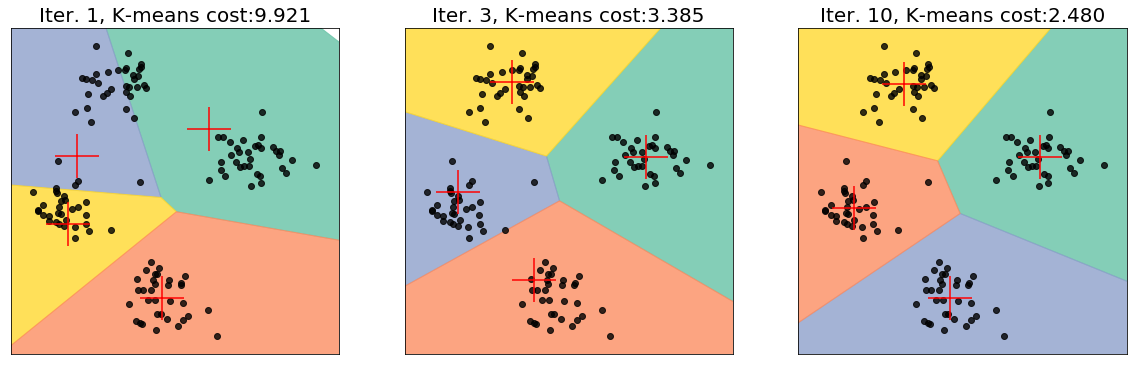

In [378]:
# colorize
cmap = cm.get_cmap('Set2')
colors = [cmap(0), cmap(0.3), cmap(0.7), cmap(1)]

params = {'axes.titlesize':'20'}
plt.rcParams.update(params)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[20,6])
ax = [ax1, ax2, ax3]

for idx, i in enumerate([1, 3, 10]):
    kmeans = KMeans(init='random', n_clusters=4, n_init=1, max_iter=i)
    kmeans.fit(X)
    centroids = kmeans.cluster_centers_
    vor = Voronoi(centroids)
    regions, vertices = voronoi_finite_polygons_2d(vor)

    for region, color in zip(sorted(regions), colors):
        polygon = vertices[region]
        ax[idx].fill(*zip(*polygon), alpha=0.8, color = color, zorder=1)
        
    ax[idx].scatter(centroids[:, 0], centroids[:, 1],
                marker='+', s=2000, 
                color='red', zorder=3)
    
    ax[idx].scatter(X[:,0],X[:,1], color = "black", marker = "o", alpha=0.8, zorder=2)
    title = "Iter. " + str(i)+ ", K-means cost:" + str(-kmeans.score(X))[:5]
    ax[idx].title.set_text(title)
    ax[idx].set_xlim(x_min, x_max)
    ax[idx].set_ylim(y_min, y_max)
    ax[idx].set_xticks(())
    ax[idx].set_yticks(())
f.savefig("./TeX_files/voronoi_kmeans",dpi=200, transparent=True, bbox_inches='tight', pad_inches=0)

In [463]:
X = np.zeros([133,2])
X[:33] = np.random.multivariate_normal([0.1, 0.1], 5e-3*np.diag(np.ones(2)),33)
X[33:66] = np.random.multivariate_normal([0.3, 0.8], 5e-3*np.diag(np.ones(2)),33)
X[66:100] = np.random.multivariate_normal([0.9, 0.4], 5e-3*np.diag(np.ones(2)),34)
X[100:133] = np.random.multivariate_normal([0.5, -0.4], 5e-3*np.diag(np.ones(2)),33)

In [480]:
from scipy.cluster import hierarchy

X2 = X
Z = hierarchy.linkage(X2, 'single')
Z_c = hierarchy.linkage(X2, 'complete')
Z_w = hierarchy.linkage(X2, 'ward')


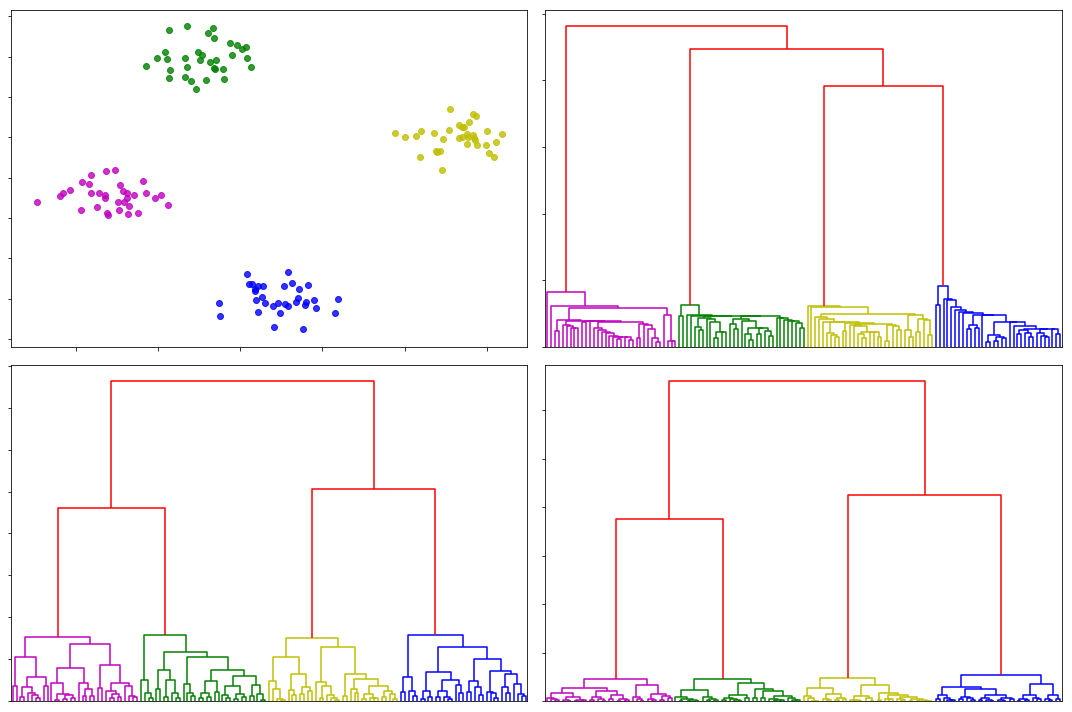

In [481]:
hierarchy.set_link_color_palette(['m', 'g', 'y', 'b'])
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
dn1 = hierarchy.dendrogram(Z, ax=axes[0,1], above_threshold_color='r',#color_threshold=10,
                           orientation='top', no_labels=True)
dn_c = hierarchy.dendrogram(Z_c, ax=axes[1,0], above_threshold_color='r', color_threshold=0.5,
                           orientation='top', no_labels=True)
dn_w = hierarchy.dendrogram(Z_w, ax=axes[1,1], above_threshold_color='r', color_threshold=1,
                           orientation='top', no_labels=True)
axes[0,0].scatter(X2[:33,0], X2[:33,1], color = "m", marker = "o", alpha=0.8, zorder=2)
axes[0,0].scatter(X2[33:66,0], X2[33:66,1], color = "g", marker = "o", alpha=0.8, zorder=2)
axes[0,0].scatter(X2[66:100,0], X2[66:100,1], color = "y", marker = "o", alpha=0.8, zorder=2)
axes[0,0].scatter(X2[100:133,0],X2[100:133,1], color = "b", marker = "o", alpha=0.8, zorder=2)
#hierarchy.set_link_color_palette(None)  # reset to default after use
for ax in axes:
    for a in ax:
        a.set_xticklabels([])
        a.set_yticklabels([])
fig.tight_layout()
fig.savefig("./TeX_files/dendrogram",dpi=200, transparent=True, bbox_inches='tight', pad_inches=0)